<a href="https://colab.research.google.com/github/srilav/machinelearning/blob/main/v1_Girish_copy_12th_Oct_M3_NB_MiniProject_3_Dementia_prediction_SVM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Dementia prediction using SVM

## Problem Statement

Prediction of Dementia using an SVM model on brain MRI features

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data exploration, preprocessing and visualization
* implement SVM Classifier on the data
* explore various parameters of SVM classifier and implement OneVsOne classifier
* calculate the metrics and plot the roc_curve

## Information

**About Dementia**

Dementia is a general term for loss of memory and other mental abilities severe enough to interfere with daily life. It is caused by physical changes in the brain. Alzheimer's is the most common type of dementia, but there are many kinds.

**Brain Imaging via magnetic resonance imaging (MRI) and Machine Learning**

* MRI is used for the evaluation of patients with suspected Alzheimer's disease
* MRIs detect both, local and generalized shrinkage of brain tissue.
* MRI features predict the rate of decline of AD and may guide therapy in the future
* Using machine learning on MRI features could help in automatedly and accurately predicting the progress of a patient from mild cognitive impairment to dementia

To understand the basics of MRI technique, you could refer [here](https://case.edu/med/neurology/NR/MRI%20Basics.htm)

## Dataset

The dataset chosen for this mini-project is [OASIS - Longitudinal brain MRI Dataset](https://www.oasis-brains.org/). This dataset consists of a longitudinal MRI collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

**Dataset fields:**

* Subject ID - Subject Identification
* MRI ID - MRI Exam Identification
* Group - Target variable with 3 labels ('NonDemented', 'Demented', 'Converted')
* Visit - Visit order
* MR Delay - MR Delay Time (Contrast)
* M/F - Male or Female
* Hand - Unique value 'R'
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)
* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD)
* Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). A computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

For learning more on building a machine learning model to predict dementia using SVM, refer [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7408873/).

## Grading = 10 Points

In [ ]:
#@title Download the dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv
print("Data downloaded successfully!")

Data downloaded successfully!


### Import required packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
# sklearn imports
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Load the dataset

In [ ]:
FILE_PATH='/content/oasis_longitudinal.csv'
empty_values=['.', 'na','NA','NAN','NaN']

In [ ]:
# YOUR CODE HERE
def load_data(file_path):
  data = pd.read_csv(
    file_path, 
    header=0,
    na_values=empty_values
    )
  return data

**Dataset fields:**

* Subject ID - Subject Identification
* MRI ID - MRI Exam Identification
* Group - Target variable with 3 labels ('NonDemented', 'Demented', 'Converted')
* Visit - Visit order
* MR Delay - MR Delay Time (Contrast)
* M/F - Male or Female
* Hand - Unique value 'R'
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)
* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD)
* Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). A computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

In [ ]:
raw_df = load_data(FILE_PATH)

In [ ]:
def get_dementia_status_by_visit(visit_id):
  df_visit_status = raw_df[raw_df['Visit'] == visit_id]
  return df_visit_status['Group'].value_counts()

In [ ]:
df_visit_status_1 = raw_df[raw_df['Visit'] == 1]
df_visit_status_1['Group'].value_counts()

Nondemented    72
Demented       64
Converted      14
Name: Group, dtype: int64

In [ ]:
raw_df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


Print the unique values of CDR - Clinical Dementia Rating Score (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate)

In [ ]:
raw_df['CDR'].unique()

array([0. , 0.5, 1. , 2. ])

### Pre-processing and Data Engineering (2 points)

##### Studying the Socio Economic Status Variables (SES) - for self-study

In [ ]:
raw_df['SES'].unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

In [ ]:
raw_df['SES'].isnull().sum()

19

In [ ]:
raw_df['SES'].describe()

count    354.000000
mean       2.460452
std        1.134005
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: SES, dtype: float64

In [ ]:
raw_df_nan_ses = raw_df[~raw_df['SES'].isin(['1.0', '2.0', '3.0', '4.0', '5.0'])]
raw_df_nan_ses['EDUC'].unique()

array([12, 16])

In [ ]:
raw_df['SES'].median()

2.0

In [ ]:
raw_df['SES'].fillna(raw_df['SES'].median(), inplace=True)

In [ ]:
raw_df_nan_ses_1 = raw_df[~raw_df['SES'].isin(['1.0', '2.0', '3.0', '4.0', '5.0'])]
raw_df_nan_ses_1['EDUC'].unique()

array([], dtype=int64)

#### Remove unwanted columns

In [ ]:
drop_columns_list = ['Subject ID', 'MRI ID', 'M/F', 'Hand']

In [ ]:
# YOUR CODE HERE
df = raw_df.drop(columns=drop_columns_list)
df

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,2,842,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,3,2297,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,2,763,63,13,2.0,30.0,0.0,1327,0.796,1.323


#### Encode categorical features into numeric

In [ ]:
# YOUR CODE HERE

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_dementia_group = df['Group']
df['Group'] = encoder.fit_transform(df_dementia_group)

In [ ]:
df

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...
368,1,2,842,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,1,3,2297,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,2,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,2,2,763,63,13,2.0,30.0,0.0,1327,0.796,1.323


#### Handle the null values by removing or replacing

In [ ]:
# YOUR CODE HERE
df.columns[df.isnull().any()]

Index(['MMSE'], dtype='object')

In [ ]:
null_record_count = df['MMSE'].isnull().sum()

In [ ]:
print(f'Within the dataset of size = {df.shape[0]}, only {null_record_count} records have MMSE as null. Dropping those records')

Within the dataset of size = 373, only 2 records have MMSE as null. Dropping those records


In [ ]:
final_df = df.dropna()

In [ ]:
final_df

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...
368,1,2,842,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,1,3,2297,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,2,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,2,2,763,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [ ]:
final_df.shape

(371, 11)

#### Identify feature and target and split it into train test

In [ ]:
# YOUR CODE HERE
X = final_df.iloc[:, 1:]
y = final_df.iloc[:, 0]

In [ ]:
X.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling the data

### EDA &  Visualization (1 point)

#### Plot the distribution of all the variables using a histogram

In [ ]:
final_df.dtypes

Group         int64
Visit         int64
MR Delay      int64
Age           int64
EDUC          int64
SES         float64
MMSE        float64
CDR         float64
eTIV          int64
nWBV        float64
ASF         float64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4fdee1e850>,
      dtype=object)

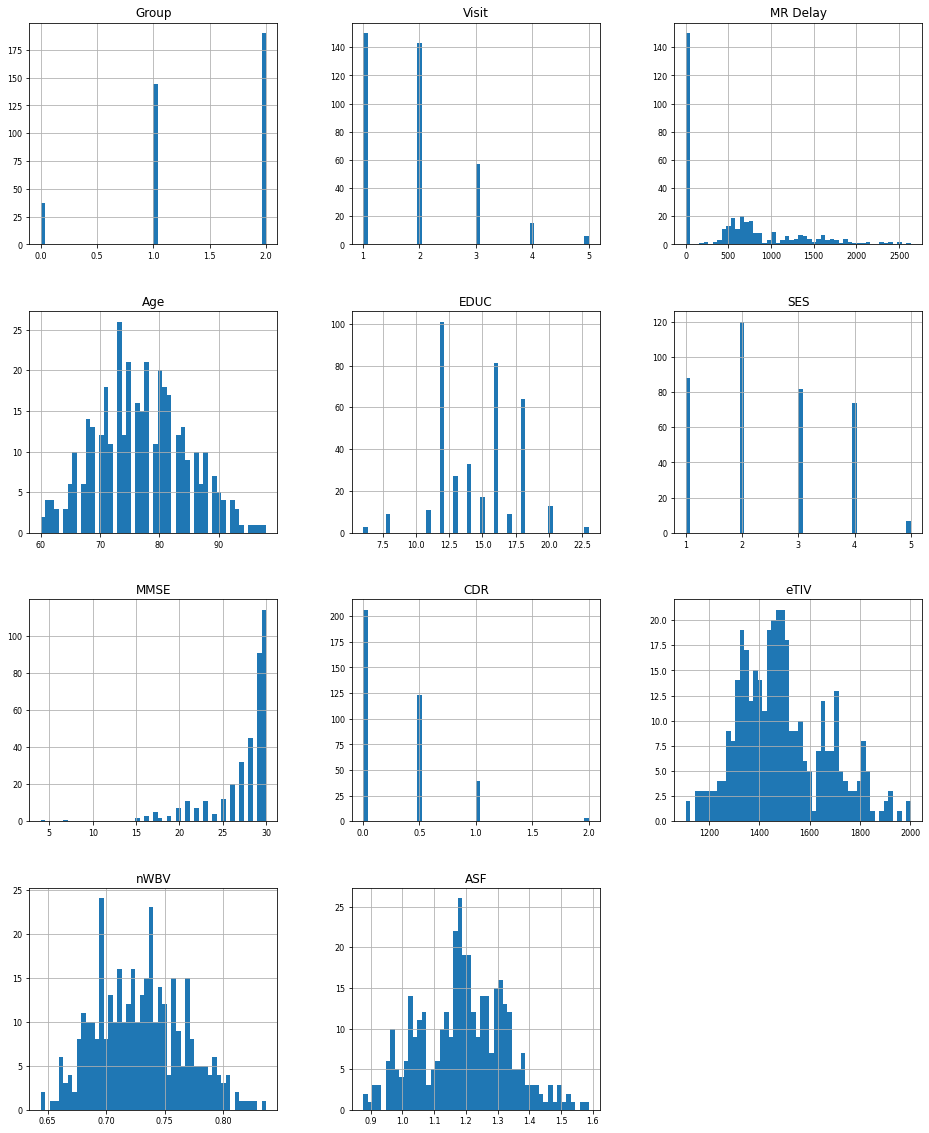

In [ ]:
# YOUR CODE HERE
final_df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

#### Visualize the frequency of Age

(array([ 2.,  4.,  4.,  3.,  0.,  3.,  6., 10.,  0.,  6., 14., 13.,  0.,
        12., 18., 11.,  0., 26., 12., 21.,  0., 16., 15., 21.,  0., 11.,
        20., 18., 17.,  0., 12., 13.,  9.,  0., 10.,  6., 10.,  0.,  7.,
         5.,  4.,  0.,  4.,  3.,  1.,  0.,  1.,  1.,  1.,  1.]),
 array([60.  , 60.76, 61.52, 62.28, 63.04, 63.8 , 64.56, 65.32, 66.08,
        66.84, 67.6 , 68.36, 69.12, 69.88, 70.64, 71.4 , 72.16, 72.92,
        73.68, 74.44, 75.2 , 75.96, 76.72, 77.48, 78.24, 79.  , 79.76,
        80.52, 81.28, 82.04, 82.8 , 83.56, 84.32, 85.08, 85.84, 86.6 ,
        87.36, 88.12, 88.88, 89.64, 90.4 , 91.16, 91.92, 92.68, 93.44,
        94.2 , 94.96, 95.72, 96.48, 97.24, 98.  ]),
 <a list of 50 Patch objects>)

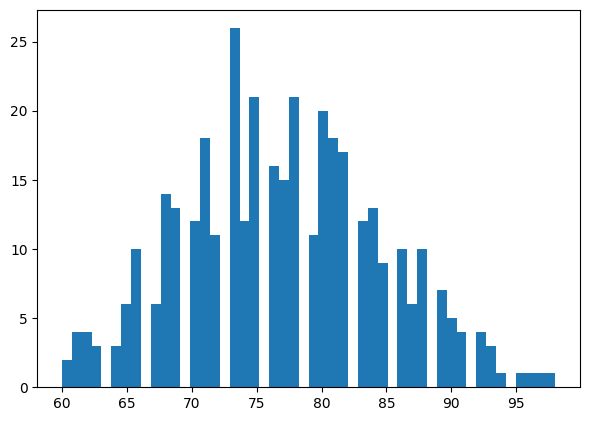

In [ ]:
# YOUR CODE HERE
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(final_df['Age'], bins=50)

#### How many people have Alzheimer? Visualize with an appropriate plot

the same person visits two or more times; extract the single visit data and plot

**Hint**: Visit = 1

In [ ]:
visit_1_df = final_df[final_df['Visit'] == 1]
visit_1_df.shape

(150, 11)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


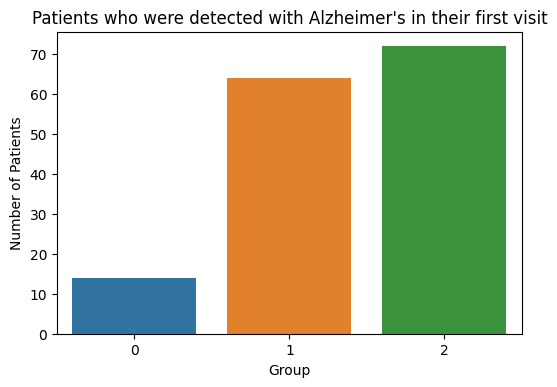

In [ ]:
# YOUR CODE HERE
plt.subplots(figsize=(6, 4))
sns.countplot('Group',data=visit_1_df)
plt.xlabel("Group")
plt.ylabel("Number of Patients")
plt.title("Patients who were detected with Alzheimer's in their first visit")
plt.show()

In [ ]:
get_dementia_status_by_visit(visit_id=1)

Nondemented    72
Demented       64
Converted      14
Name: Group, dtype: int64

#### Calculate the correlation of features and plot the heatmap

In [ ]:
def Correlation(df, bar=0.9):
  # Creates correlation matrix
  Corr = df.corr()
  
  # Set Up Mask To Hide Upper Triangle
  mask = np.triu(np.ones_like(Corr, dtype=bool))
  tri_df = Corr.mask(mask)

  # Finding features with correlation value more than specified threshold value (bar=0.9)
  highly_cor_col = [col for col in tri_df.columns if any(tri_df[col] > bar )]
  print(f"Highly correlated columns - {highly_cor_col} \n\n")
  
  #Heat map for correlation matrix of attributes
  fig,ax=plt.subplots(figsize=(15,8))
  sns.heatmap(Corr,mask=mask,vmax=1.00,vmin=-1.00,square=True,annot=True,ax=ax)
  ax.set_title('Correlation matrix of attributes')
  plt.show()

  return df

Highly correlated columns - ['Visit'] 




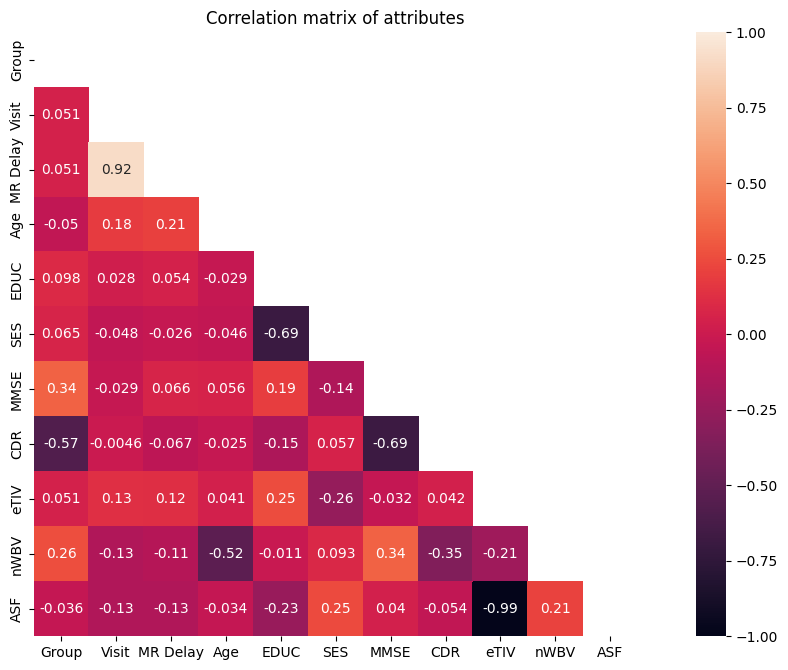

In [ ]:
# YOUR CODE HERE
final_df = Correlation(final_df)

### Model training and evaluation (4 points)

**Hint:** SVM model from sklearn

**Initializing this takes a long time (~ 4 mins) as probability=True. We will need it for the ROC curves. **

In [ ]:
# YOUR CODE HERE
svc = SVC(kernel='linear', probability=True,random_state=0, C = 10) # Setting probability=True, as we need the ROC curve
svc_clf = make_pipeline(StandardScaler(), svc)


In [ ]:
svc_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=True, random_state=0, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
# LinearSVC
#clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
#clf.fit(X_train, y_train)

In [ ]:
y_pred = svc_clf.predict(X_test)

In [ ]:
X_train.head()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
192,1,0,75,12,4.0,28.0,0.0,1511,0.739,1.162
75,4,2508,89,12,4.0,26.0,0.5,1485,0.706,1.181
84,1,0,70,17,3.0,29.0,0.0,1640,0.766,1.070
361,1,0,66,13,2.0,30.0,0.0,1495,0.746,1.174
16,2,576,69,12,2.0,24.0,0.5,1480,0.791,1.186


Text(0.5, 1.0, 'Linearly separable data - CDR (Clinical Dementia Rating) and Age')

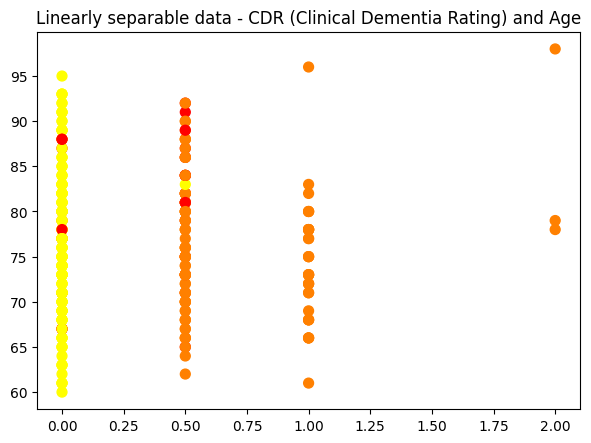

In [ ]:
plt.scatter(X_train.iloc[:, 6], X_train.iloc[:, 2], c=y_train, s=50, cmap='autumn')
plt.title('Linearly separable data - CDR (Clinical Dementia Rating) and Age')

TBD - Ask Jaley. 

1.   Is the above data linearly separable?
2.   In the below chart, can we have so many support vectors?



#### Support vectors of the model

* Find the samples of the dataset which are the support vectors of the model 

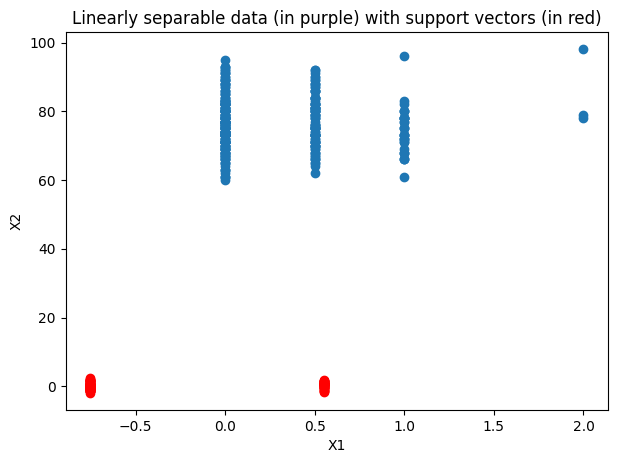

In [ ]:
support_vectors = svc.support_vectors_

# Visualize support vectors
plt.scatter(X_train.iloc[:,6], X_train.iloc[:,2])
plt.scatter(support_vectors[:,6], support_vectors[:,2], color='red')
plt.title('Linearly separable data (in purple) with support vectors (in red)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [ ]:
# YOUR CODE HERE
svc.support_vectors_.size

930

In [ ]:
svc.support_vectors_.shape

(93, 10)

In [ ]:
support_vector_indices = svc.support_
print(support_vector_indices)

[ 12  23  35  49  57  61  66  68  70  85  99 103 105 107 109 130 142 159
 163 223 242 243 251 267 294   1   6  18  32  39  56  77  90  93 101 135
 138 139 166 177 180 193 200 214 218 224 227 232 241 255  14  15  27  30
  38  41  44  46  53  59  60  73  74  75  76  78  86  88  89  94  97 116
 119 125 129 136 149 164 168 173 174 197 198 199 201 203 207 210 211 213
 222 226 234 238 244 249 252 258 271 280 289 293]


#### Confusion matrix for multi-class classification

* Predict the test and plot the confusion matrix

In [ ]:
y_pred_svc = svc_clf.predict(X_test)

In [ ]:
confusion_matrix_svc = metrics.confusion_matrix(y_test, y_pred_svc) 
confusion_matrix_svc

array([[ 2,  1,  8],
       [ 1, 31,  0],
       [ 0,  1, 31]])

**Since most results are on the main diagonal, the classification indeed looks correct**


*   0 - Converted
*   1 - Demented
*   2 - Non Demented




---



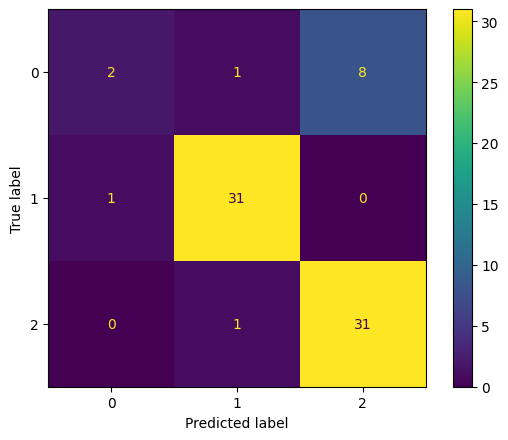

In [ ]:
metrics.plot_confusion_matrix(svc_clf, X_test, y_test)
plt.show()

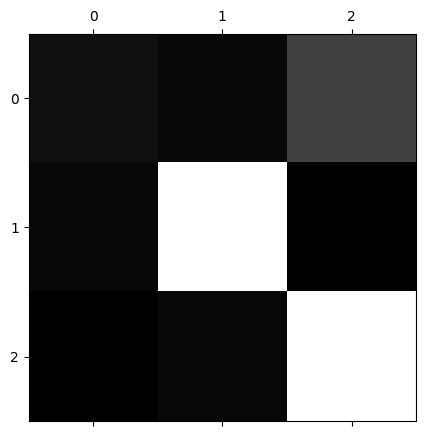

In [ ]:
plt.matshow(confusion_matrix_svc, cmap=plt.cm.gray)
plt.show()

#### One VS Rest Classifier

OneVsRestClassifier can also be used for multilabel classification. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed)

* Fit `OneVsRestClassifier` on the data and find the accuracy

Hint: [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [ ]:
clf_ovr = make_pipeline(StandardScaler(),
                    OneVsRestClassifier(LinearSVC(random_state=0, tol=1e-5)))
clf_ovr.fit(X_train, y_train)

y_pred_clf_ovr = clf_ovr.predict(X_test)
#print(y_pred_clf_ovr)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
a_score_ovr = accuracy_score(y_test, y_pred_clf_ovr)
print(f"Accuracy score with OneVsRestClassifier : {a_score_ovr}")

Accuracy score with OneVsRestClassifier : 0.8533333333333334


#### One VS One Classifier

This strategy consists of fitting one classifier per class pair. At prediction time, the class which received the most votes is selected.

* Fit `OneVsOneClassifier` on the data and find the accuracy

Hint: [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

In [ ]:
clf_ovo = make_pipeline(StandardScaler(),
                    OneVsOneClassifier(LinearSVC(random_state=0, tol=1e-5)))
clf_ovo.fit(X_train, y_train)

y_pred_clf_ovo = clf_ovr.predict(X_test)

In [ ]:
a_score_ovo = accuracy_score(y_test, y_pred_clf_ovo)
print(f"Accuracy score with OneVsOneClassifier : {a_score_ovo}")

Accuracy score with OneVsOneClassifier : 0.8533333333333334


#### Make it binary classification

As stated in the dataset description, 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit. Change `Converted` label into `Demented`.

**Note:** In two-class classification, encode the labels into numerical to plot the roc_curve with predictions.

In [ ]:
df['Group'].unique()

array(['Nondemented', 'Demented', 'Converted'], dtype=object)

In [ ]:
df.head()

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [ ]:
y[]

In [ ]:
def converterGroupBinary(Group):
    if Group == 0 or Group == 1:
        return 1
    else: 
        return 2

In [ ]:
final_df['Group'] = final_df['Group'].apply(converterGroupBinary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_df['Group'].unique()

array([2, 1])

In [ ]:
final_df.head()

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,2,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,2,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [ ]:
X_b = final_df.iloc[:, 1:].values                  
y_b = final_df.iloc[:, 0].values

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size = 0.25, random_state=0)

In [ ]:

svc_b = SVC(kernel='linear', probability=True,random_state=0)
clf_b = make_pipeline(StandardScaler(), svc_b)
clf_b.fit(X_train_b, y_train_b)

y_pred_b = clf_b.predict(X_test_b)

In [ ]:
a_score_b = accuracy_score(y_test_b, y_pred_b)
print(f"Accuracy score with Binary : {a_score_b}")

Accuracy score with Binary : 0.956989247311828


#### Compare the performance and predictions of both multi-class and binary classifications

In [ ]:
#Precision
print(f'Precision score for binary classification : {precision_score(y_test_b,y_pred_b)} \n')
print(f"Precision score for multiclass classification : {precision_score(y_test,y_pred_svc, average='micro')} \n")
print(f"Precision score for multiclass - OneVsRest classification : {precision_score(y_test,y_pred_clf_ovr,average='micro')} \n")
print(f"Precision score for multiclass - OneVsOne classification : {precision_score(y_test,y_pred_clf_ovo,average='micro')} \n")

Precision score for binary classification : 1.0 

Precision score for multiclass classification : 0.8533333333333334 

Precision score for multiclass - OneVsRest classification : 0.8533333333333334 

Precision score for multiclass - OneVsOne classification : 0.8533333333333334 



In [ ]:
#Recall


### Classification report and metrics (2 points)

#### Confusion matrix

Describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
# YOUR CODE HERE

#### Plot the ROC Curve

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

In [ ]:
# YOUR CODE HERE
svc_prob = svc.predict_proba(X_test)
preds = svc_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds, pos_label=2)

In [ ]:
svc_prob

array([[1.86347503e-01, 7.53888597e-02, 7.38263637e-01],
       [5.35430183e-02, 5.67937491e-03, 9.40777607e-01],
       [1.94744987e-01, 8.30327519e-02, 7.22222261e-01],
       [6.74589394e-02, 9.13286817e-03, 9.23408192e-01],
       [5.16718841e-02, 5.28186028e-03, 9.43046256e-01],
       [1.99643673e-01, 8.77131988e-02, 7.12643128e-01],
       [2.35793464e-01, 1.27902329e-01, 6.36304207e-01],
       [2.61827413e-02, 1.34428362e-03, 9.72472975e-01],
       [5.84429827e-02, 6.79429556e-03, 9.34762722e-01],
       [2.00885565e-01, 8.89264633e-02, 7.10187972e-01],
       [2.16025026e-01, 1.04627373e-01, 6.79347602e-01],
       [1.25789753e-01, 3.27678378e-02, 8.41442409e-01],
       [4.98308904e-03, 5.04673929e-08, 9.95016860e-01],
       [5.37535122e-02, 5.72506239e-03, 9.40521425e-01],
       [3.00189824e-01, 2.35271398e-01, 4.64538778e-01],
       [1.10529905e-02, 2.41322806e-04, 9.88705687e-01],
       [2.21712217e-02, 9.64718046e-04, 9.76864060e-01],
       [1.84782852e-01, 7.40160

In [ ]:
roc_auc = metrics.auc(fpr, tpr)

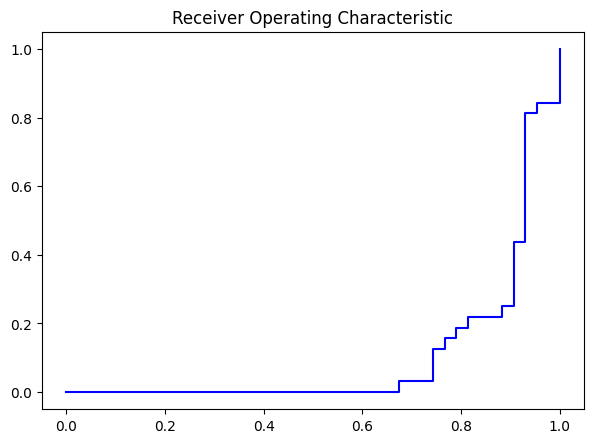

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

### Choice of C for SVM (1 point)

experiment with different C values given and plot the ROC curve for each

In [ ]:
c_val = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# YOUR CODE HERE

### Report Analysis

* Compare the performance of the model with various Kernel parameters.
* Discuss the impact of parameter C and gamma on performance.
* Comment on the computational cost of implementing one vs one and one vs all to solve multi-class classification with binary classifier.
* When do you call a sample/record in the data as a support vector?